# Flow-based entropic regularization for $W_1$ optimal transport

This notebook showcases the Flow Sinkhorn algorithm for approximating the $W_1$ Wasserstein distance on graphs.

The algorithm uses entropic regularization on flow variables and provides fast approximate solutions to the optimal transport problem.

In [ ]:
# Install Flow Sinkhorn from GitHub (for Colab)
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print('Running on Colab - installing flowsinkhorn from GitHub...')
    !pip install -q git+https://github.com/gpeyre/flow-sinkhorn.git
    !pip install -q sparse
    print('Installation complete!')
else:
    print('Running locally - using local flowsinkhorn')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import time
import warnings
import sys

# Add parent directory to path when running locally (not needed on Colab)
try:
    import google.colab
except ImportError:
    sys.path.insert(0, '..')

# Import Flow Sinkhorn toolbox
from flowsinkhorn import sinkhorn_w1, sinkhorn_w1_sparse, solve_w1_exact

warnings.filterwarnings('ignore')

## Data generation

Generate a random planar K-NN graph.

In [3]:
n = 200
X = np.random.rand(2, n)
k = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X.T)
distances, indices = nbrs.kneighbors(X.T)
A = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in indices[i]:
        A[i, j] = 1
        A[j, i] = 1  # Ensure the graph is undirected
    A[i, i] = 0

Create source (>0) and destination (<0) mass vector $z$ with zero total mean.

In [4]:
z = np.zeros(n)
z[np.argmin(X[1]+X[0])] = 1
z[np.argmax(X[1]+X[0])] = -1
p = 1
for _ in range(p):  # diffuse a bit on the graph
    z = A @ z + z
z = np.sign(z)
z[z > 0] = z[z > 0] / np.sum(z[z > 0]) 
z[z < 0] = -z[z < 0] / np.sum(z[z < 0])

Display the graph with source/destination nodes in red/blue.

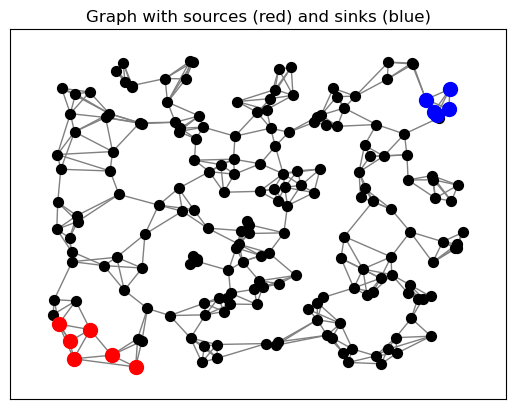

In [5]:
G = nx.from_numpy_array(A)
pos = {k: X[:, k] for k in range(n)}
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z > 0)[0], node_color='red', node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z < 0)[0], node_color='blue', node_size=100)
plt.title('Graph with sources (red) and sinks (blue)')
plt.show()

## Exact solver using linear programming

Solve using CVXPY the linear program:
$$
    \min_{F \in \mathbb{R}_+^{n \times n}} \{ \langle F,W \rangle  \;:\; F^\top 1 - F 1 = z \}. 
$$
The variable $F_{i,j}$ is the flow from node $j$ to node $i$. This compact representation enforces at optimality that either $F_{i,j}$ or $F_{j,i}$ is 0.

In [6]:
# Create cost matrix: large for non-edges
W = 1 / (A + 1e-6)

# Solve exact problem
F, obj_val, status = solve_w1_exact(W, z)
print(f'Exact solver status: {status}')
print(f'Optimal cost: {obj_val:.6f}')

Exact solver status: optimal
Optimal cost: 18.033320


Display the flow variable on the edges.

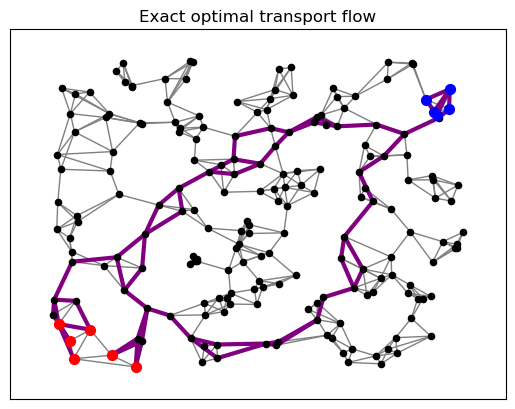

In [7]:
tol = 1e-5
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=20, width=1)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z > 0)[0], node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z < 0)[0], node_color='blue', node_size=50)
edges_to_draw = [(i, j) for i in range(n) for j in range(n) if F[i, j] > tol]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='purple', width=3, node_size=0)
plt.title('Exact optimal transport flow')
plt.show()

## $W_1$ Sinkhorn Algorithm

The $W_1$-Sinkhorn algorithm computes:
$$
    f = e^{\frac{-W_{i,j} + h_i - h_j }{\varepsilon} }
$$
with the iterations:
$$
    h \longleftarrow \frac{h}{2} - \frac{\varepsilon}{2}  m 
$$
where:
$$
    m := \log( \sqrt{ r^2 + a \odot b } + r ) - \log(b)
$$
and:
$$
    a_i := \sum_j e^{\frac{-W_{i,j} - h_i }{\varepsilon}}, \quad
    b_i := \sum_j e^{\frac{-W_{i,j} + h_i }{\varepsilon}}
$$

### Comparison: Dense vs Sparse implementation

In [ ]:
import sparse

# Create sparse cost matrix (need to specify shape for sparse.COO)
n = len(z)
Ws = sparse.COO(A.nonzero(), A[A.nonzero()], shape=(n, n), fill_value=1e9)
W = 1 / (A + 1e-9)  # Dense cost matrix

epsilon = 0.01 * 5
niter = 3000

# Dense Sinkhorn
start = time.time()
f, err, h = sinkhorn_w1(Ws.todense(), z, epsilon=epsilon, niter=niter)
time_dense = time.time() - start
print(f'Dense Sinkhorn: {time_dense:.3f}s')

# Sparse Sinkhorn
start = time.time()
fs, errs, hs = sinkhorn_w1_sparse(Ws, z, epsilon=epsilon, niter=niter)
time_sparse = time.time() - start
print(f'Sparse Sinkhorn: {time_sparse:.3f}s')
print(f'Speedup: {time_dense/time_sparse:.2f}x')

### Convergence analysis

Plot the evolution of the error $\| f^\top 1 - f 1 - z \|_1$ over iterations.

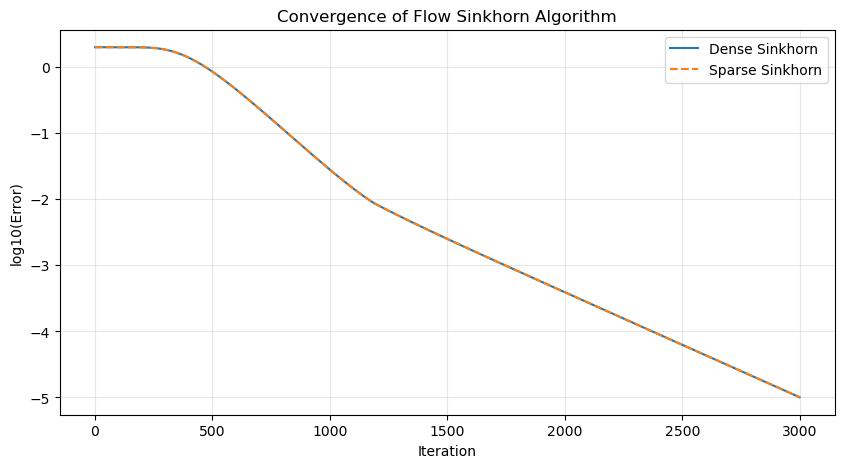

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(err), label='Dense Sinkhorn')
plt.plot(np.log10(errs), '--', label='Sparse Sinkhorn')
plt.xlabel('Iteration')
plt.ylabel('log10(Error)')
plt.title('Convergence of Flow Sinkhorn Algorithm')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Visualization of approximate flow

Display a thresholded flow from the Sinkhorn algorithm.

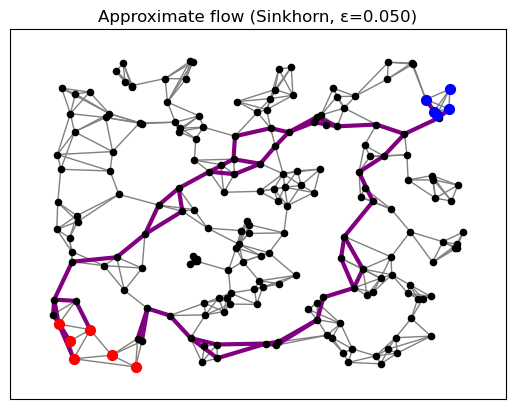

In [11]:
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=20, width=1)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z > 0)[0], node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z < 0)[0], node_color='blue', node_size=50)
edges_to_draw = [(i, j) for i in range(n) for j in range(n) if f[i, j] > f.max() / 10]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='purple', width=3, node_size=0)
plt.title(f'Approximate flow (Sinkhorn, ε={epsilon:.3f})')
plt.show()

## Comparison of exact vs approximate solutions

In [12]:
# Compute costs
exact_cost = obj_val
approx_cost = np.sum(f * W)

print(f"\nCost comparison:")
print(f"Exact cost:       {exact_cost:.6f}")
print(f"Approximate cost: {approx_cost:.6f}")
print(f"Relative error:   {abs(approx_cost - exact_cost) / exact_cost * 100:.2f}%")


Cost comparison:
Exact cost:       18.033320
Approximate cost: 18.105806
Relative error:   0.40%


## Effect of regularization parameter $\varepsilon$

Test different values of epsilon to see the trade-off between speed and accuracy.

ε = 0.1000: cost = 18.845295, final error = 1.98e-05
ε = 0.0500: cost = 18.105655, final error = 3.93e-04
ε = 0.0100: cost = nan, final error = nan
ε = 0.0050: cost = nan, final error = nan


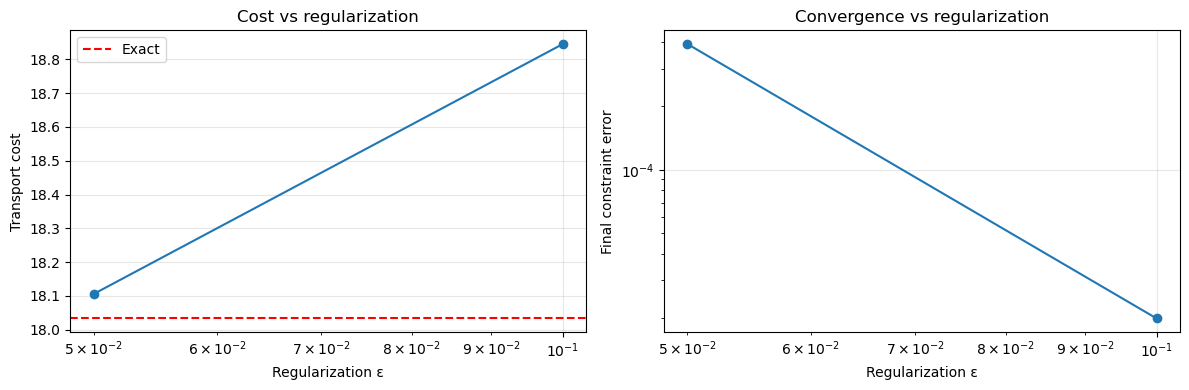

In [13]:
epsilons = [0.1, 0.05, 0.01, 0.005]
costs = []
final_errors = []

for eps in epsilons:
    f_test, err_test, h_test = sinkhorn_w1(W, z, epsilon=eps, niter=2000)
    cost = np.sum(f_test * W)
    costs.append(cost)
    final_errors.append(err_test[-1])
    print(f"ε = {eps:.4f}: cost = {cost:.6f}, final error = {err_test[-1]:.2e}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.semilogx(epsilons, costs, 'o-')
ax1.axhline(y=exact_cost, color='r', linestyle='--', label='Exact')
ax1.set_xlabel('Regularization ε')
ax1.set_ylabel('Transport cost')
ax1.set_title('Cost vs regularization')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.loglog(epsilons, final_errors, 'o-')
ax2.set_xlabel('Regularization ε')
ax2.set_ylabel('Final constraint error')
ax2.set_title('Convergence vs regularization')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()